
# 1 - Imports and defining functions

In [1]:
import sys
import os

meshplot_folder = '/home/s94zalek/shape_matching/meshplot_fork'
sys.path.append(meshplot_folder)
os.chdir(meshplot_folder)
import meshplot as mp

base_folder = '/home/s94zalek/shape_matching/pyFM_fork'

sys.path.append(base_folder)
os.chdir(base_folder)

In [2]:
import numpy as np

from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

import meshplot as mp

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

# 2- Loading and processing a mesh

### Basic Mesh methods

A TriMesh class can be created from a path (to a .off or a .obj file) or simply an array of vertices and an optional array of faces.

The mesh can be centered, area-normalized, rotated or translated when loading.


Vertices and faces are stored in the 'vertlist' and 'facelist' attributes. One can also use 'mesh.vertices' and 'mesh.faces' to access them. While these notations can feel non-intuitive they result in clearer functions as it avoids expressions of the form ```mesh.vertices - vertices```.

A TriMesh class possess multiple attributes like edges, per-face area, per-vertex area, per-face normals, per-vertex normals, ...

In [3]:
mesh1 = TriMesh('/home/s94zalek/shape_matching/data/FAUST_r/off/tr_reg_040.off', area_normalize=True, center=False)
mesh2 = TriMesh(mesh1.vertlist, mesh1.facelist)

In [4]:
# Attributes are computed on the fly and cached
edges = mesh1.edges

area = mesh1.area

face_areas = mesh1.face_areas
vertex_areas = mesh1.vertex_areas
face_normals = mesh1.normals

# AREA WEIGHTED VERTEX NORMALS
vertex_normals_a = mesh1.vertex_normals

# UNIFORM WEIGHTED VERTEX NORMALS
mesh1.set_vertex_normal_weighting('uniform')
vertex_normals_u = mesh1.vertex_normals

### Geodesics

We propose three versions to compute geodesics :
- Heat method - based on [potpourri3d](https://github.com/nmwsharp/potpourri3d) using robust laplacian (recommended)
- Heat method - pure python implementation from pyFM (not robust but control on the whole code)
- Dijkstra

In [5]:
# Geodesic distance from a given index
# Usses potpourri3d by default. Set robust to False to obtain result from the Python implementation
# Set robust to False to obtain result from the Python implementation
dists = mesh1.geod_from(1000, robust=True)

In [6]:
# Similar arguments can be passed as above. I recommand sticking to the default values.
S1_geod = mesh1.get_geodesic(verbose=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

### Laplacian and functions

The spectrum of the LBO can be computed easily.

Eigenvalues and eigenvectors are stored in the ```mesh.eigenvalues``` and ```mesh.eigenvectors``` attributes.

Gradient and divergence can be computed using the associated methods. Using the ```mesh.project``` and ```mesh.unproject``` functions allows to switch between seeing a function in the LBO basis or on the complete shape.

The squared $L^2$ norm and $H^1_0$ norm can be computed via the ```mesh.l2_sqnorm``` and ```mesh.h1_sqnorm``` methods.

In [7]:
# By default does not use the intrinsic delaunay Laplacian.
# For functional map methods, I'd recommend setting intrinsic to True.
mesh1.process(k=100, intrinsic=False, verbose=True);

Computing 100 eigenvectors
	Done in 0.40 s


In [8]:
# plot the third eigenfunction
plot_mesh(mesh1, mesh1.eigenvectors[:,5])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.019770…

# 3 - Computing the functional map

**Loading data**

In [9]:
mesh1 = TriMesh('/home/s94zalek/shape_matching/data/FAUST_r/off/tr_reg_040.off')
mesh2 = TriMesh('/home/s94zalek/shape_matching/data/FAUST_r/off/tr_reg_023.off')
print(f'Mesh 1 : {mesh1.n_vertices:4d} vertices, {mesh1.n_faces:5d} faces\n'
      f'Mesh 2 : {mesh2.n_vertices:4d} vertices, {mesh2.n_faces:5d} faces')

# double_plot(mesh1,mesh2)

Mesh 1 : 5001 vertices,  9998 faces
Mesh 2 : 5000 vertices,  9996 faces


**Computing descriptors**

In [54]:
process_params = {
    'n_ev': (100,100),  # Number of eigenvalues on source and Target
    # 'landmarks': np.loadtxt('examples/data/landmarks.txt',dtype=int)[:5],  # loading 5 landmarks
    'subsample_step': 1,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}

model = FunctionalMapping(mesh1,mesh2)
model.preprocess(**process_params,verbose=True)


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 1.00 s
Computing 200 eigenvectors
	Done in 0.94 s

Computing descriptors
	Normalizing descriptors

	100 out of 100 possible descriptors kept


**Fitting the model**

$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\uargmin}[1]{\underset{#1}{\text{argmin}}\;}$
$\newcommand{\uargmax}[1]{\underset{#1}{\text{argmax}}\;}$
$\def\*#1{\mathbf{#1}}$

In pyFM, we always consider functional maps $\*C:\Ss_1\to\Ss_2$ and pointwise maps $T:\Ss_2\to\Ss_1$ going in opposite directions, with $\*C$ always going from shape 1 to shape 2 !

Optimization problem is
\begin{equation}
\uargmin{\*C\in\RR^{k_2\times k_1}} w_{descr}\|\*C\*A - \*B\|^2 + w_{lap}\|\*C\Delta_1 - \Delta_2\*C\|^2 + w_{\text{d- comm}}\sum_i \|\*C\Gamma_1^i - \Gamma_2^i\*C\|^2 + w_{\text{orient}}\sum_i \|\*C\Lambda_1^i - \Lambda_2^i\*C\|^2
\end{equation}

with $\Gamma_1^i$ and $\Gamma_2^i$ [multiplicative operators](http://www.lix.polytechnique.fr/~maks/papers/fundescEG17.pdf) associated to the $i$-th descriptors, $\Lambda_1^i$ and $\Lambda_2^i$ [orientation preserving operators](https://arxiv.org/abs/1806.04455) associated to the $i$-th descriptors

In [11]:
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1,
    'w_orient': 0
}



model.fit(**fit_params, verbose=True)

Computing commutativity operators
	Scaling LBO commutativity weight by 4.1e-10

Optimization :
	100 Ev on source - 100 Ev on Target
	Using 100 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e+00
		Laplacian commutativity :1.0e-02
		Orientation preservation :0.0e+00

	Task : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH, funcall : 179, nit : 175, warnflag : 0
	Done in 7.52 seconds


**Visualizing the associated point to point map**

In [12]:
p2p_21 = model.get_p2p(n_jobs=1)
fmap_12 = model.FM

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
# double_plot(mesh1,mesh2,cmap1,cmap2)

# 4 - Refining the Functional Map
```model.FM``` returns the current state of functional map. One can change which one is returned by using ```model.change_FM_type(FM_type)```, as one can see below. 

**ICP**

In [13]:
model.icp_refine(verbose=True)
p2p_21_icp = model.get_p2p()
fmap_12_icp = model.FM

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_icp]
# double_plot(mesh1,mesh2,cmap1,cmap2)

  0%|          | 0/10 [00:00<?, ?it/s]

**Zoomout**

In [14]:
model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one
model.zoomout_refine(nit=15, step = 1, verbose=True)
print(model.FM.shape)
p2p_21_zo = model.get_p2p()
fmap_12_zo = model.FM

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_zo]
# double_plot(mesh1,mesh2,cmap1,cmap2)

  0%|          | 0/15 [00:00<?, ?it/s]

(115, 115)


# Evaluating Results

In [15]:
import pyFM.eval

In [16]:
# Compute geodesic distance matrix on the cat mesh
A_geod = mesh1.get_geodesic(verbose=True)
A_geod_2 = mesh2.get_geodesic(verbose=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
counts = np.unique(p2p_21, return_counts=True)
counts = sorted(zip(*counts), key=lambda x: x[1], reverse=True)

n_to_print = 10
for i in zip(*counts):
    print(i)
    
    n_to_print -= 1
    if n_to_print == 0:
        break

(1919, 3601, 3705, 3650, 3778, 1093, 715, 3743, 2071, 209, 3322, 118, 4890, 575, 1771, 2383, 767, 4746, 792, 74, 489, 2032, 952, 1590, 3095, 3920, 4120, 4263, 38, 819, 4297, 576, 3354, 168, 410, 692, 1416, 1535, 1548, 3960, 4047, 203, 208, 248, 411, 716, 1546, 2719, 3092, 4338, 488, 1802, 1962, 1978, 2269, 2343, 2816, 2964, 3905, 3966, 4309, 4894, 13, 247, 786, 1456, 1544, 1809, 2449, 2450, 3453, 3836, 4531, 169, 1329, 1457, 1858, 1943, 2249, 2744, 2747, 3073, 3837, 3949, 3998, 4272, 4659, 4896, 202, 332, 544, 545, 682, 820, 821, 968, 1270, 1545, 1621, 1806, 1837, 1908, 2141, 2425, 2948, 3221, 3319, 3332, 41, 119, 128, 319, 362, 450, 721, 808, 958, 971, 981, 1605, 1951, 2020, 2117, 2121, 2154, 2186, 2198, 2344, 2409, 2626, 2718, 2970, 3074, 3240, 3262, 3353, 3913, 4009, 4027, 4041, 4105, 4799, 4883, 4986, 170, 249, 260, 321, 338, 449, 616, 630, 759, 787, 882, 1328, 1608, 1673, 1738, 1826, 1834, 1838, 1864, 1920, 1964, 2003, 2018, 2037, 2111, 2163, 2250, 2424, 2484, 2595, 2777, 2988, 32

In [18]:
# GT correspondences

corr_1 = np.loadtxt('/home/s94zalek/shape_matching/data/FAUST_r/corres/tr_reg_040.vts',dtype=int) - 1
corr_2 = np.loadtxt('/home/s94zalek/shape_matching/data/FAUST_r/corres/tr_reg_023.vts', dtype=int) - 1

In [19]:
import pyFM.spectral


C_gt_xy_lstsq = np.linalg.lstsq(
    model.mesh2.eigenvectors[corr_2],
    model.mesh1.eigenvectors[corr_1],
    )[0]

p2p_21_GT = pyFM.spectral.convert.FM_to_p2p(C_gt_xy_lstsq, model.mesh1.eigenvectors, model.mesh2.eigenvectors)
p2p_21_GT

/tmp/ipykernel_500354/1747389904.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C_gt_xy_lstsq = np.linalg.lstsq(


array([  67,  137,  122, ..., 4997, 4405, 4360])

In [30]:
model.descr1.shape

(5001, 100)

In [102]:
Cxy_lstsq = np.linalg.lstsq(
    # (model.mesh1.eigenvectors.T @ model.mesh1.A @ model.descr1).T,
    # (model.mesh2.eigenvectors.T @ model.mesh2.A @ model.descr2).T,
    model.project(model.descr1, mesh_ind=1).T,  # (n_ev1, n_descr)
    model.project(model.descr2, mesh_ind=2).T,  # (n_ev2, n_descr)
    )[0].T

p2p_21_lstsq = pyFM.spectral.convert.mesh_FM_to_p2p(Cxy_lstsq, model.mesh1, model.mesh2)
# self.eigenvectors.T @ (self.A

/tmp/ipykernel_500354/1442628238.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Cxy_lstsq = np.linalg.lstsq(


In [104]:
Cxy_lstsq.min(), Cxy_lstsq.max()

(-151619.2581487053, 177154.41533411268)

In [62]:
model.descr1.shape

(5001, 100)

In [67]:
model.project(model.descr1, mesh_ind=1).T.shape

(100, 100)

In [56]:
model.k1

100

In [103]:
pinv_1 = np.linalg.pinv(model.project(model.descr1, mesh_ind=1)[2:, 2:])
pinv_1.min(), pinv_1.max()

(-8604268.647235965, 7077076.573989342)

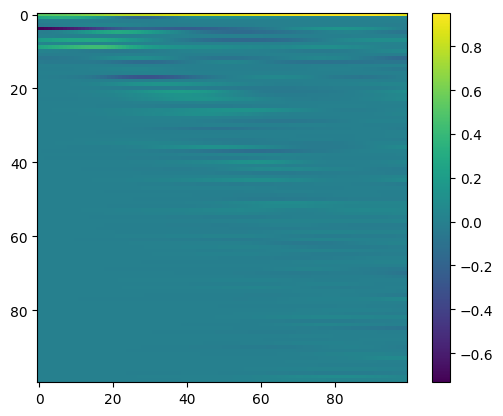

In [78]:
plt.imshow(model.project(model.descr1, mesh_ind=1))
plt.colorbar()

In [105]:
sys.path.append('/home/s94zalek/shape_matching')
import metrics.geodist_metric as geodist_metric


# Load an approximate ground truth map
# gt_p2p = np.loadtxt('examples/data/lion2cat',dtype=int)



gt_p2p = p2p_21_GT

geo_err_gt = geodist_metric.calculate_geodesic_error(A_geod, corr_1, corr_2, p2p_21_GT, return_mean=False).sum()   
geo_err_lstsq = geodist_metric.calculate_geodesic_error(A_geod, corr_1, corr_2, p2p_21_lstsq, return_mean=False).sum()

geo_err_base = geodist_metric.calculate_geodesic_error(A_geod, corr_1, corr_2, p2p_21, return_mean=False).sum()
geo_err_icp = geodist_metric.calculate_geodesic_error(A_geod, corr_1, corr_2, p2p_21_icp, return_mean=False).sum()
geo_err_zo = geodist_metric.calculate_geodesic_error(A_geod, corr_1, corr_2, p2p_21_zo, return_mean=False).sum()
    
    
    
print(f'geo_err_gt : {geo_err_gt}')
print(f'geo_err_lstsq : {geo_err_lstsq}')
print(f'geo_err_base : {geo_err_base}')
print(f'geo_err_icp : {geo_err_icp}')
print(f'geo_err_zo : {geo_err_zo}')


acc_base = pyFM.eval.accuracy(p2p_21, gt_p2p, A_geod, sqrt_area=mesh1.sqrtarea)

acc_lstsq = pyFM.eval.accuracy(p2p_21_lstsq, gt_p2p, A_geod, sqrt_area=np.sqrt(mesh1.area))

acc_icp = pyFM.eval.accuracy(p2p_21_icp, gt_p2p, A_geod, sqrt_area=np.sqrt(mesh1.area))

acc_zo = pyFM.eval.accuracy(p2p_21_zo, gt_p2p, A_geod, sqrt_area=np.sqrt(mesh1.area))

print(f'Accuracy results\n'
      f'\tBasic FM : {1e3*acc_base:.2f}\n'
      f'\tLeast squares : {1e3*acc_lstsq:.2f}\n'
      f'\tICP refined : {1e3*acc_icp:.2f}\n'
      f'\tZoomOut refined : {1e3*acc_zo:.2f}\n')

geo_err_gt : 446.5448987450194
geo_err_lstsq : 2855.143015717882
geo_err_base : 1590.1423108619522
geo_err_icp : 1516.476019733947
geo_err_zo : 1521.3040496402443
Accuracy results
	Basic FM : 528.88
	Least squares : 959.21
	ICP refined : 503.95
	ZoomOut refined : 506.92



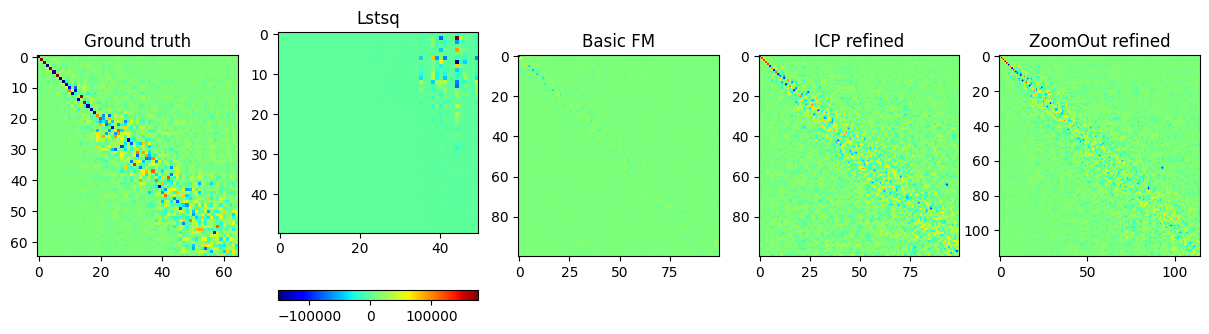

In [106]:
C_gt_xy_lstsq, Cxy_lstsq
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(15, 5))

ax[0].imshow(C_gt_xy_lstsq[:65, :65], cmap='jet', vmin=-1, vmax=1)
ax[0].set_title('Ground truth')

ax_1 = ax[1].imshow(Cxy_lstsq[:65, :65], cmap='jet')#, vmin=-1, vmax=1)
# add colorbar
cbar = fig.colorbar(ax_1, ax=ax[1], orientation='horizontal')
ax[1].set_title('Lstsq')

ax[2].imshow(fmap_12, cmap='jet', vmin=-1, vmax=1)
ax[2].set_title('Basic FM')

ax[3].imshow(fmap_12_icp, cmap='jet', vmin=-1, vmax=1)
ax[3].set_title('ICP refined')

ax[4].imshow(fmap_12_zo, cmap='jet', vmin=-1, vmax=1)
ax[4].set_title('ZoomOut refined')

plt.show()